In [1]:
%matplotlib inline
%matplotlib notebook
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [10]:
engine.execute('SELECT * FROM measurement LIMIT 5').fetchall()

[(1, 'USC00519397', '2010-01-01', 0.08, 65.0),
 (2, 'USC00519397', '2010-01-02', 0.0, 63.0),
 (3, 'USC00519397', '2010-01-03', 0.0, 74.0),
 (4, 'USC00519397', '2010-01-04', 0.0, 76.0),
 (5, 'USC00519397', '2010-01-06', None, 73.0)]

In [11]:
# Inspect columns in class
inspector = inspect(engine)
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
# Inspect columns in class
inspector = inspect(engine)
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Earliest Date
session.query(Measurement.date).order_by(Measurement.date).first()

('2010-01-01')

In [14]:
# Latest Date
current_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
current_date

('2017-08-23')

In [15]:
# Calculate the date 1 year ago from the last data point in the database
query_date = dt.date(2017,8, 23) - dt.timedelta(days=365)
print("Query Date: ", query_date)

Query Date:  2016-08-23


# Exploratory Climate Analysis

In [16]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
precip_data = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date > query_date).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
precip_data


[('2016-08-24', 1.45),
 ('2016-08-25', 0.11),
 ('2016-08-26', 0.01),
 ('2016-08-27', None),
 ('2016-08-28', 2.07),
 ('2016-08-29', 0.9),
 ('2016-08-30', 0.05),
 ('2016-08-31', 2.46),
 ('2016-09-01', 0.01),
 ('2016-09-02', 0.03),
 ('2016-09-03', 1.0),
 ('2016-09-04', 0.44),
 ('2016-09-05', 0.18),
 ('2016-09-06', 1.0),
 ('2016-09-07', 1.35),
 ('2016-09-08', 0.15),
 ('2016-09-09', 0.35),
 ('2016-09-10', 1.16),
 ('2016-09-11', 0.6),
 ('2016-09-12', 1.04),
 ('2016-09-13', 1.2),
 ('2016-09-14', 6.7),
 ('2016-09-15', 3.35),
 ('2016-09-16', 0.61),
 ('2016-09-17', 0.23),
 ('2016-09-18', 0.42),
 ('2016-09-19', 0.25),
 ('2016-09-20', 0.43),
 ('2016-09-21', 1.02),
 ('2016-09-22', 0.75),
 ('2016-09-23', 0.33),
 ('2016-09-24', 0.27),
 ('2016-09-25', 0.04),
 ('2016-09-26', 1.02),
 ('2016-09-27', 1.0),
 ('2016-09-28', 0.05),
 ('2016-09-29', 1.49),
 ('2016-09-30', 0.38),
 ('2016-10-01', 1.02),
 ('2016-10-02', 0.61),
 ('2016-10-03', 0.46),
 ('2016-10-04', 3.46),
 ('2016-10-05', 0.81),
 ('2016-10-06', 0.

In [17]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precip_df = pd.DataFrame(precip_data, columns=['date', 'prcp'])
precip_df.set_index('date', inplace=True)

precip_df.head()

,prcp
date,
2016-08-24,1.45
2016-08-25,0.11
2016-08-26,0.01
2016-08-27,NaN
2016-08-28,2.07


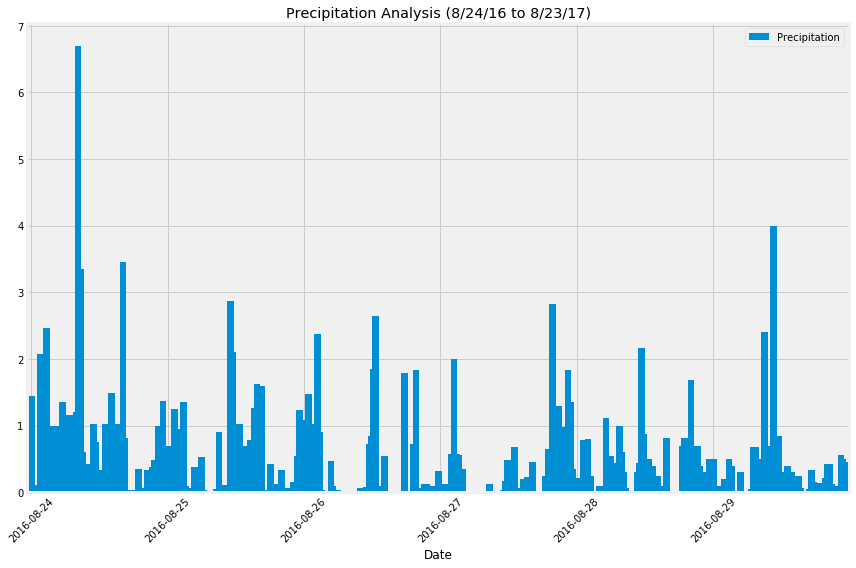

In [18]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = precip_df.plot(kind='bar', width=3, figsize=(12,8))
plt.locator_params(axis='x', nbins=6)
plt.xlabel("Date")
plt.title("Precipitation Analysis (8/24/16 to 8/23/17)")
plt.legend(["Precipitation"])
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("Precipitation_12months.png")
plt.show()


![precipitation](Images/precipitation.png)

In [19]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precip_df.describe()

,prcp
count,344.000000
mean,0.431308
std,0.705240
min,0.000000
25%,0.010000
50%,0.140000
75%,0.565000
max,6.700000


![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?
session.query(Station.id).count()

9

In [21]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
stat_rows = session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
stat_rows

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [22]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature most active station?
most_active_stat = stat_rows[0][0]
session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
                filter(Measurement.station == most_active_stat).all()


[(54.0, 71.66378066378067, 85.0)]

In [23]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
highest_stat = session.query(Measurement.station, Measurement.tobs).\
                filter(Measurement.station == most_active_stat).\
                filter(Measurement.date >= query_date).all()

tobs_df = pd.DataFrame(highest_stat, columns=['station', 'tobs'])
tobs_df.set_index('station', inplace=True)
tobs_df.head()

,tobs
station,
USC00519281,77.0
USC00519281,77.0
USC00519281,80.0
USC00519281,80.0
USC00519281,75.0


<function matplotlib.pyplot.show(*args, **kw)>

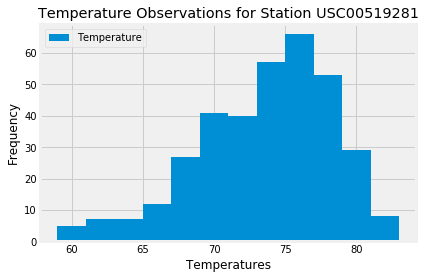

In [24]:
# Plot the results as a histogram with bins=12.
tobs_df.plot.hist(highest_stat, bins=12)
plt.title("Temperature Observations for Station " + most_active_stat)
plt.xlabel("Temperatures")
plt.legend(["Temperature"])
plt.savefig("StationTemps.png")
plt.show


![precipitation](Images/station-histogram.png)

In [25]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [26]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
trip_start = dt.date(2018, 7, 1)
trip_end = dt.date(2018, 7, 15)
previous_year = dt.timedelta(days=365)
prev_year_temps = calc_temps(trip_start-previous_year, trip_end-previous_year)
print(prev_year_temps)
min_temp, avg_temp, max_temp = prev_year_temps[0]
print(min_temp, avg_temp, max_temp)


[(69.0, 78.25, 87.0)]
69.0 78.25 87.0


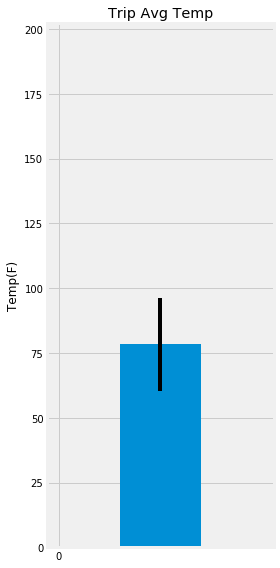

In [27]:
# Plot the results from your previous query as a bar chart. 
xpos = 1
yerr = max_temp - min_temp
fig, ax = plt.subplots(figsize=plt.figaspect(2.))

# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
# Build the plot
bar = ax.bar(xpos, avg_temp, yerr= yerr, align = "center")
ax.set(xticks=range(xpos),title = "Trip Avg Temp", ylabel = 'Temp(F)')

# Use "Trip Avg Temp" as your Title
ax.margins(.9,1.1)
fig.tight_layout()
plt.savefig('Temp Analysis 2017.png')
plt.show()



In [43]:
# Calculate the rainfall per weather station for your trip dates using the previous year's matching dates.



# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [29]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [30]:
# calculate the daily normals for your trip
prev_year_temps = calc_temps(trip_start-previous_year, trip_end-previous_year)
print(prev_year_temps)
min_temp, avg_temp, max_temp = prev_year_temps[0]
print(min_temp, avg_temp, max_temp)


# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates
# Dates will be the same as the

# Stip off the year and save a list of %m-%d strings


# Loop through the list of %m-%d strings and calculate the normals for each date


[(69.0, 78.25, 87.0)]
69.0 78.25 87.0


In [31]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [32]:
# Plot the daily normals as an area plot with `stacked=False`
